# Statsmodels Code Utils

This notebook includes different code utils for Statsmodels in Time Series.

In [1]:
# Import Standard Libraries
from datetime import datetime
import pandas as pd
from pandas.plotting import lag_plot
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.stattools import acf, pacf, pacf_yw, adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from pmdarima.arima import auto_arima

In [2]:
# Read data
macrodata_dataset = pd.read_csv('./../../data/raw/macrodata.csv', 
                                index_col=0,
                                parse_dates=True)
passengers_dataset = pd.read_csv('./../../data/raw/airline_passengers.csv',
                                 index_col=0, 
                                 parse_dates=True)
daily_female_births = pd.read_csv('./../../data/raw/daily_female_births.csv', 
                                  index_col='Date', 
                                  parse_dates=True)
us_population = pd.read_csv('./../../data/raw/us_population.csv', 
                            index_col='Date', 
                            parse_dates=True)
granger_causality_data = pd.read_csv('./../../data/raw/samples.csv', 
                                     index_col=0, 
                                     parse_dates=True)
trade_inventories_data = pd.read_csv('./../../data/raw/trade_inventories.csv', 
                                     index_col='Date', 
                                     parse_dates=True)
co2_mm_mlo_data = pd.read_csv('./../../data/raw/co2_mm_mlo.csv')
restaurant_visitors_data = pd.read_csv('./../../data/raw/restaurant_visitors.csv', 
                                       index_col='date', 
                                       parse_dates=True, 
                                       date_format='%m/%d/%Y')

# Operations

## Hodrick-Prescott Filter

It is used to extract the trend and cyclic components from a time series.

<Axes: >

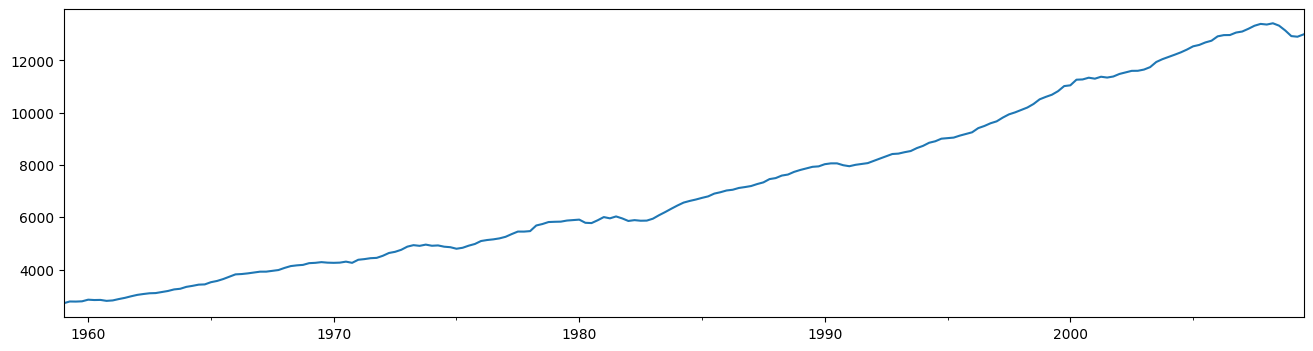

In [3]:
# Let's see the data
macrodata_dataset['realgdp'].plot(figsize=(16, 4))

In [4]:
# Use HP filter to separate trand component from cyclic one
gdp_cyclic, gdp_trend = hpfilter(macrodata_dataset['realgdp'], lamb=1600)

In [5]:
# Add gdp_trend back to dataframe
macrodata_dataset['gdp_trend'] = gdp_trend

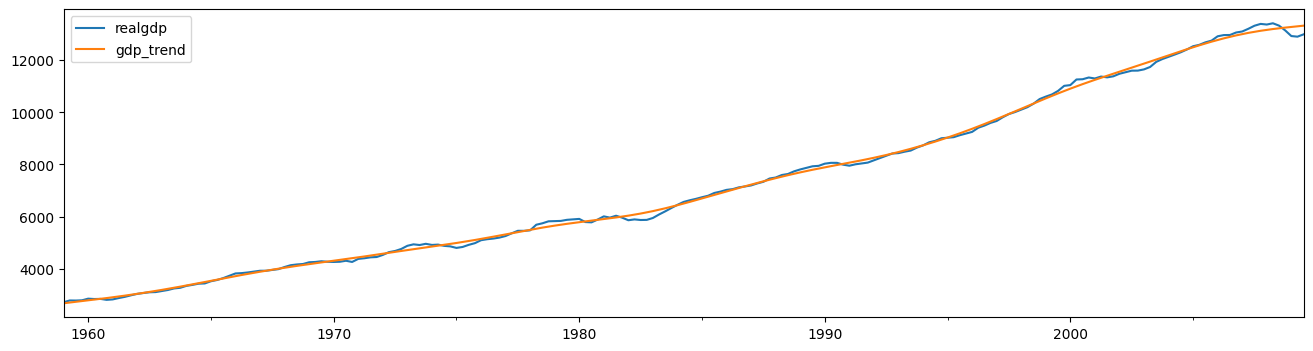

In [6]:
# Plot gdp_trend vs realgdp
_ = macrodata_dataset[['realgdp', 'gdp_trend']].plot(figsize=(16, 4))

In [7]:
macrodata_dataset.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,gdp_trend
1959-03-31,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00,2670.837085
1959-06-30,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,2698.712468
1959-09-30,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,2726.612545
1959-12-31,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06,2754.612067
1960-03-31,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19,2782.816333


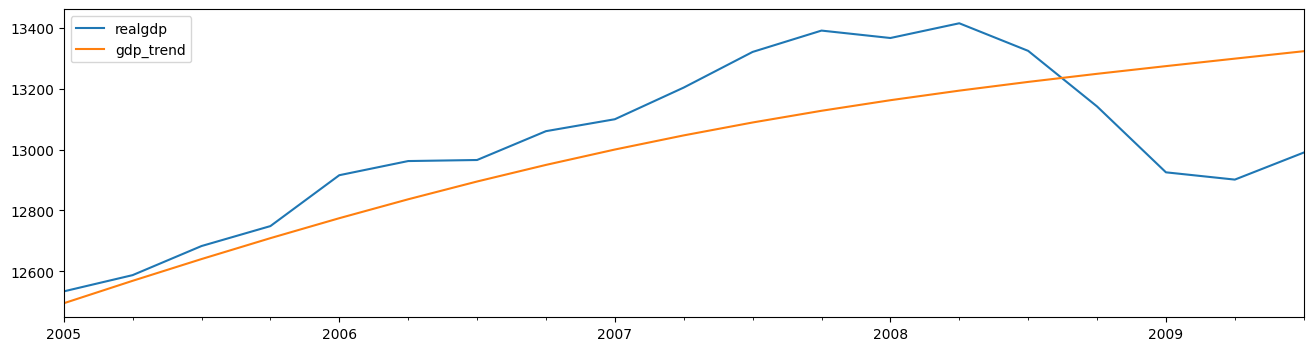

In [8]:
# Focus on just before the 2008 economic crisis
_ = macrodata_dataset[['realgdp', 'gdp_trend']].loc['2005-01-01':, :].plot(figsize=(16, 4))

## ETS Decomposition

It is used to extract the following components from a time series: trend, seasonality and error.

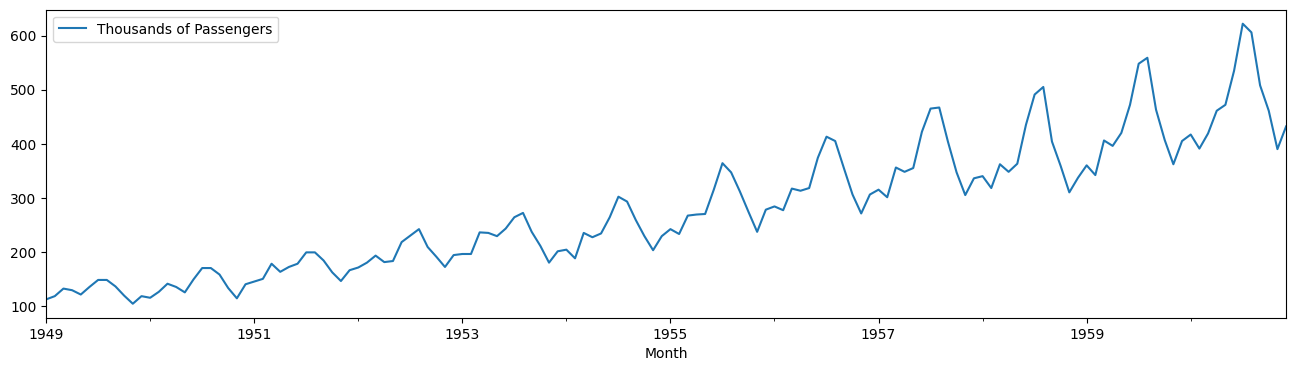

In [9]:
# Let's look at the data
_ = passengers_dataset.plot(figsize=(16, 4))

In [10]:
# Extract the components from the time series
passengers_dataset_components = seasonal_decompose(passengers_dataset['Thousands of Passengers'], 
                                                   model='multiplicative')

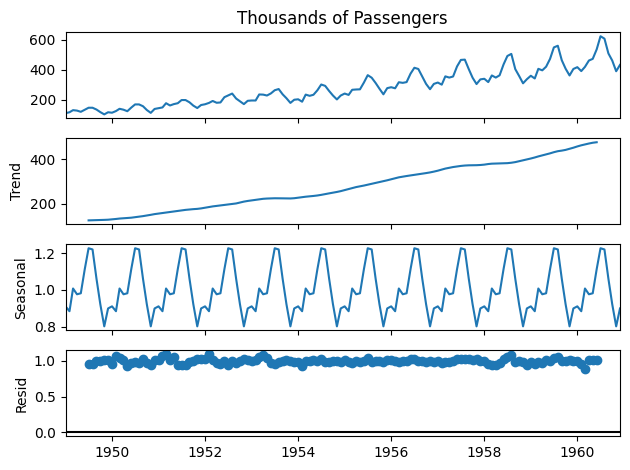

In [11]:
# NOTE: First plot is the time series itself
_ = passengers_dataset_components.plot()

## ACF & PACF

### Computation

In [12]:
# Retrieve data
stationary_data =  daily_female_births.copy()
non_stationary_data = passengers_dataset.copy()

# Prepare data
stationary_data.index.freq = 'D'
non_stationary_data.index.freq = 'MS'

In [13]:
# Compute autocorrelation with 4 lags
# NOTE: 1 is the autocorrelation for lag '0'
acf(non_stationary_data['Thousands of Passengers'], nlags=4)

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542])

In [14]:
# PACF possibilities
print(f'PACF: {pacf(non_stationary_data['Thousands of Passengers'], nlags=4)}')
print(f'PACF YW: {pacf_yw(non_stationary_data['Thousands of Passengers'], nlags=4, method='mle')}')

PACF: [ 1.          0.95467704 -0.26527732  0.05546955  0.10885622]
PACF YW: [ 1.          0.94804734 -0.22942187  0.03814778  0.09378544]


### Plots

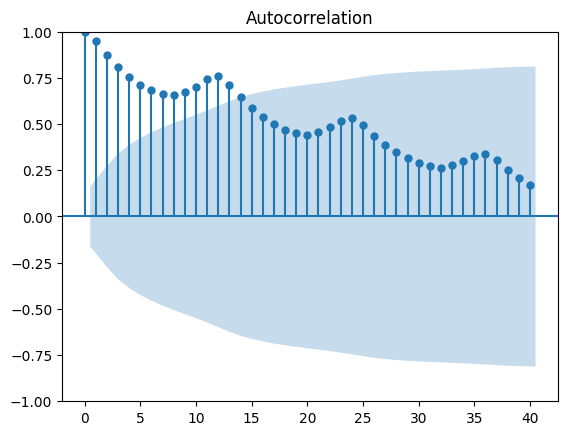

In [41]:
# Plot ACF
_ = plot_acf(non_stationary_data['Thousands of Passengers'], lags=40)

- The peaks indicate clear seasonality in the data
- Values of lags outside the shaded zone have a high change (95% confidence) to have a high correlation

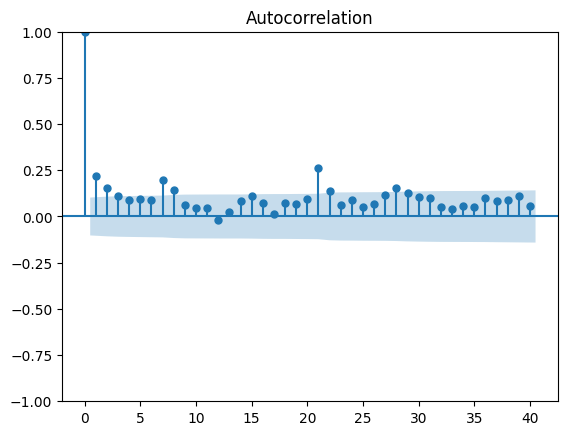

In [42]:
_ = plot_acf(stationary_data['Births'], lags=40)

- Usually partial autocorrelation works better with stationary data

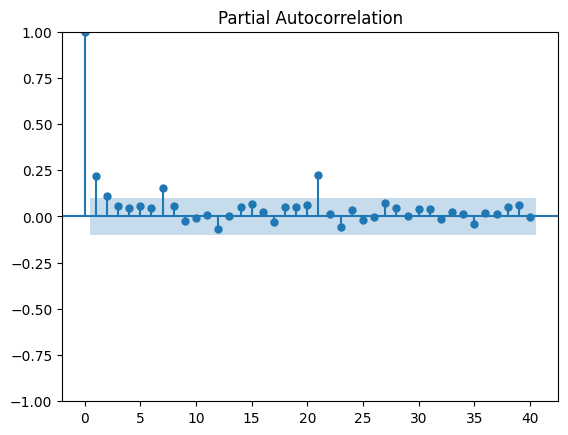

In [44]:
_ = plot_pacf(stationary_data['Births'], lags=40)

## Lag plot

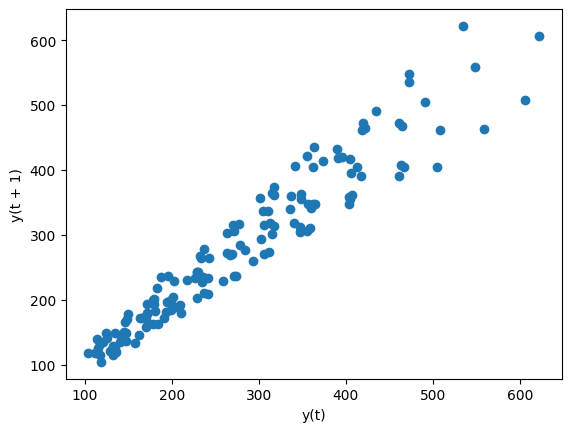

In [15]:
_ = lag_plot(non_stationary_data['Thousands of Passengers'])

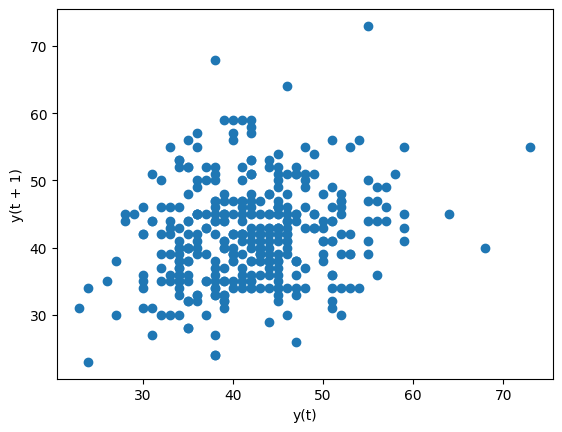

In [36]:
_ = lag_plot(stationary_data['Births'])

# Statistical Tests

## Augmented Dickey-Fuller Test

It performs a Null Hypothesis test to check whether the Time Series is stationary or not.

In [3]:
# Retrieve data
dickey_fuller_data = passengers_dataset.copy()

# Change index frequency to 'MS'
dickey_fuller_data.index.freq = 'MS'

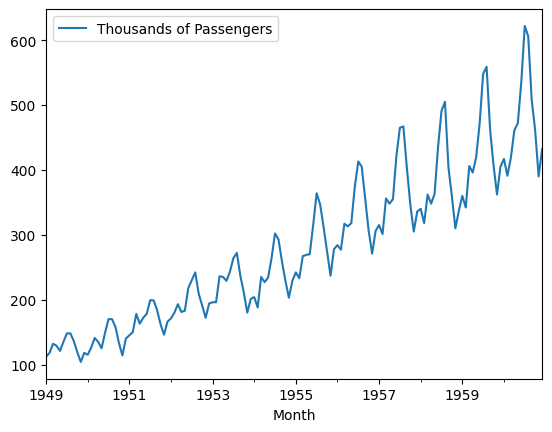

In [10]:
_ = dickey_fuller_data.plot()

In [8]:
# Perform the test
df_test = adfuller(dickey_fuller_data['Thousands of Passengers'])
df_output = pd.Series(df_test[0:4], index=['ADF Test Statistics', 
                                           'P-Value', 
                                           '# Lags Used', 
                                           '# Observations']).rename('Value')

In [9]:
df_output

ADF Test Statistics      0.815369
P-Value                  0.991880
# Lags Used             13.000000
# Observations         130.000000
Name: Value, dtype: float64

- The `p-value` is high and thus we can not reject the null hypothesis &rarr; The Time Series is non-stationary (as you can also see from the plot above)

In [12]:
# Let's check an example of stationary time series
dickey_fuller_stationary_data = daily_female_births.copy()
dickey_fuller_stationary_data.index.freq = 'D'

# Perform the test
df_test = adfuller(dickey_fuller_stationary_data['Births'])
df_output = pd.Series(df_test[0:4], index=['ADF Test Statistics', 
                                           'P-Value', 
                                           '# Lags Used', 
                                           '# Observations']).rename('Value')

In [13]:
df_output

ADF Test Statistics     -4.808291
P-Value                  0.000052
# Lags Used              6.000000
# Observations         358.000000
Name: Value, dtype: float64

- The `p-value` is very low, thus we can reject the null hypothesis &rarr; Time Series is stationary

## Granger Causality Test

It is a classic hypothesis test that measure whether one time series can forecast another one.

In [15]:
# Retrieve data
granger_causality_data.index.freq = 'MS'

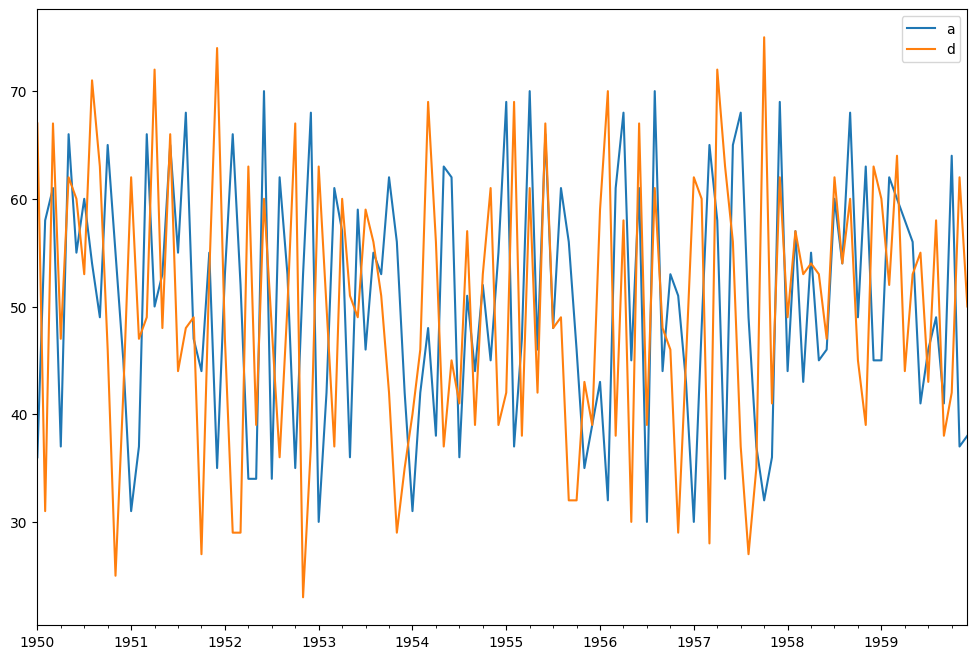

In [17]:
# Look the data
_ = granger_causality_data[['a', 'd']].plot(figsize=(12, 8))

- It is hard to tell whether there is a causality by just looking at the plot (There is actually a causality, because `d` is generated by shifting it in the future by 2 lags)

In [19]:
# Perform the data
grangercausalitytests(granger_causality_data[['a', 'd']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


{1: ({'ssr_ftest': (1.70512510516811, 0.1942027811635688, 116.0, 1),
   'ssr_chi2test': (1.7492231682328025, 0.18597442074424253, 1),
   'lrtest': (1.7364915553187075, 0.18758398456227507, 1),
   'params_ftest': (1.7051251051681275, 0.1942027811635669, 116.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (286.033942625561, 6.025362015680817e-45, 113.0, 2),
   'ssr_chi2test': (597.3806235365698, 1.907417667905223e-130, 2),
   'lrtest': (212.65135382912024, 6.658022084670506e-47, 2),
   'params_ftest': (286.03394262556435, 6.025362015677438e-45, 113.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (188.7446232861624, 3.2288482941467694e-43, 110.0, 3),
   'ssr_chi2test': (602.2669343040274, 3.2505045874681137e-130, 3),
   'lrtest': (212.4788575746154, 8.480665715595584e-46, 3),
   'params_ftest': (188.74462328615994, 3.2288482941487054e-43, 110.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],


- It is important to look for very low p-values, like for number of lags equals to 2

# Modeling

## EWMA

The Exponentially Weighted Moving Average models a time series by giving more importance to the latest data points.

In [17]:
# Compute the EWMA
passengers_dataset['EWM-12'] = passengers_dataset['Thousands of Passengers'].ewm(span=12).mean()

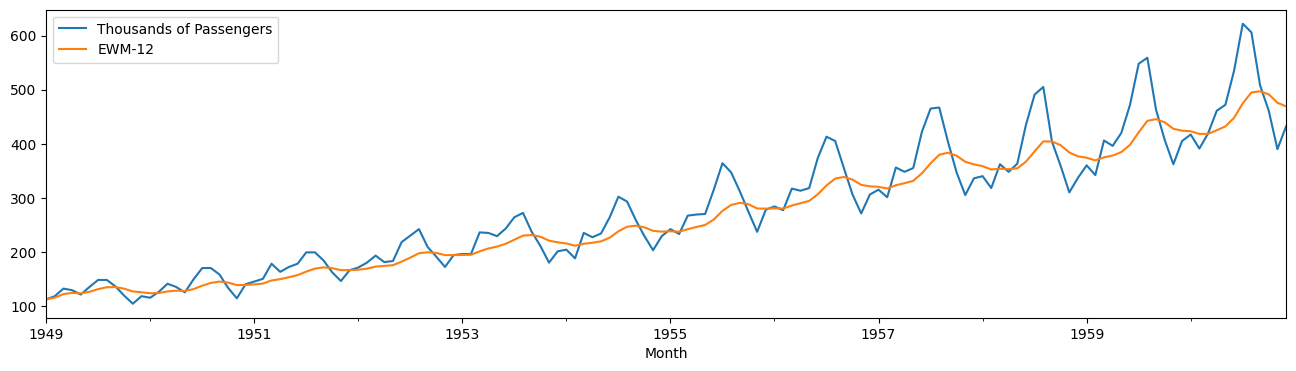

In [18]:
# Plot Time Series vs EWMA
_ = passengers_dataset[['Thousands of Passengers', 'EWM-12']].plot(figsize=(16, 4))

## Holt-Winters Modeling

In [19]:
# We need to check for the 'freq' of the observations
passengers_dataset.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [20]:
# Set the index frequency to 'Monthly Start'
passengers_dataset.index.freq = 'MS'

### Simple Exponential Smoothing

It is the same implementation has EWMA.

In [21]:
# Define model parameters
span = 12 # Dataset has yearly cycles
alpha = 2/(span + 1) # Standard formula for 'alpha' smoothing parameter

In [22]:
# Define the model
ses_model = SimpleExpSmoothing(passengers_dataset['Thousands of Passengers'])

# Fit the model
ses_model_fitted = ses_model.fit(smoothing_level=alpha, 
                                 optimized=False)

# Save the data
passengers_dataset['SES12'] = ses_model_fitted.fittedvalues.shift(-1)

In [23]:
# Compare results from EMWA to SES
print('SES Values:')
print(passengers_dataset['SES12'].head(3))

print('EMWA Values:')
print(passengers_dataset['EWM-12'].head(3))

SES Values:
Month
1949-01-01    112.000000
1949-02-01    112.923077
1949-03-01    115.857988
Freq: MS, Name: SES12, dtype: float64
EMWA Values:
Month
1949-01-01    112.000000
1949-02-01    115.250000
1949-03-01    121.787529
Freq: MS, Name: EWM-12, dtype: float64


<Axes: xlabel='Month'>

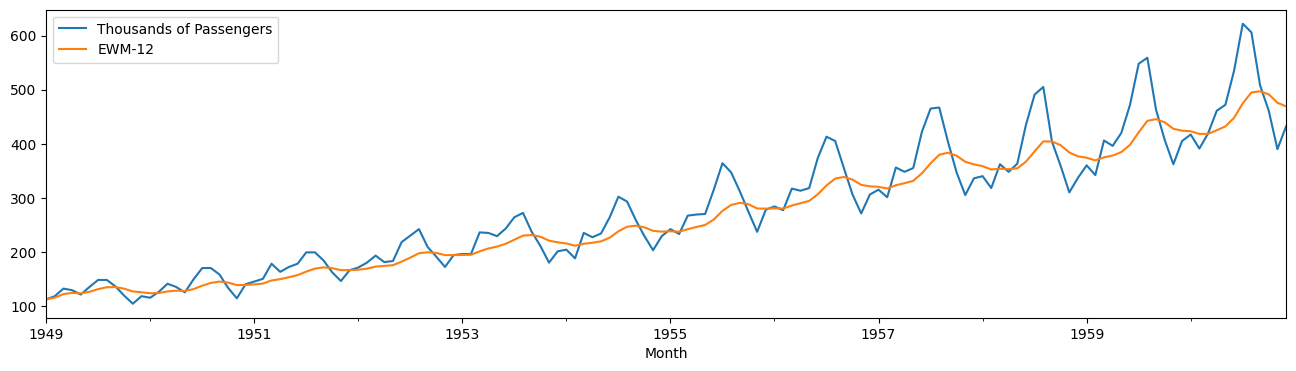

In [24]:
passengers_dataset[['Thousands of Passengers', 'EWM-12']].plot(figsize=(16, 4))

### Double Exponential Smoothing

It extracts the trend component for modelling the Time Series.

In [25]:
# Define the model
des_model = ExponentialSmoothing(passengers_dataset['Thousands of Passengers'], trend='add')

# Fit the model
des_model = des_model.fit()

# Save the data
passengers_dataset['DES_add_12'] = des_model.fittedvalues.shift(-1)

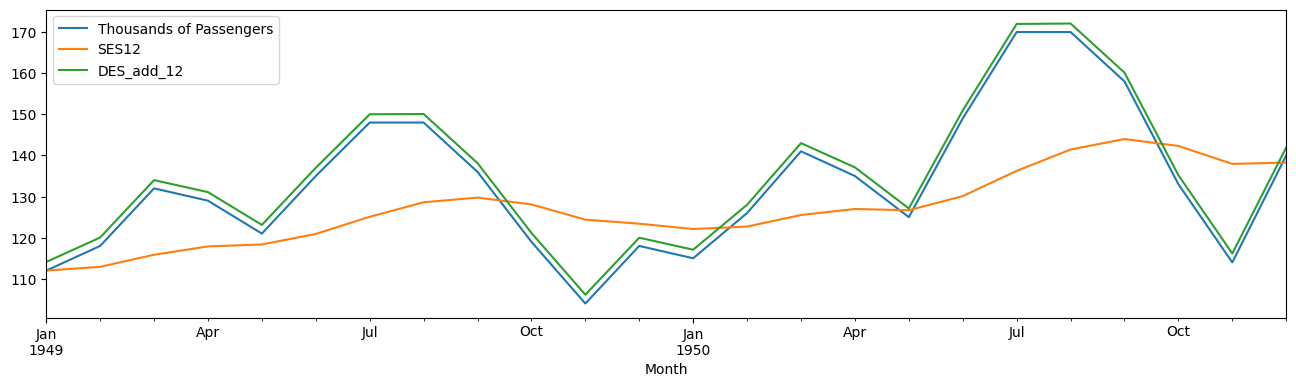

In [26]:
_ = passengers_dataset[['Thousands of Passengers', 'SES12', 'DES_add_12']].iloc[:24].plot(figsize=(16, 4))

- DES and real Time Series are pretty close!

In [27]:
# Let's now try with a multiplicative model
des_model = ExponentialSmoothing(passengers_dataset['Thousands of Passengers'], trend='mul')
des_model = des_model.fit()
passengers_dataset['DES_mul_12'] = des_model.fittedvalues.shift(-1)

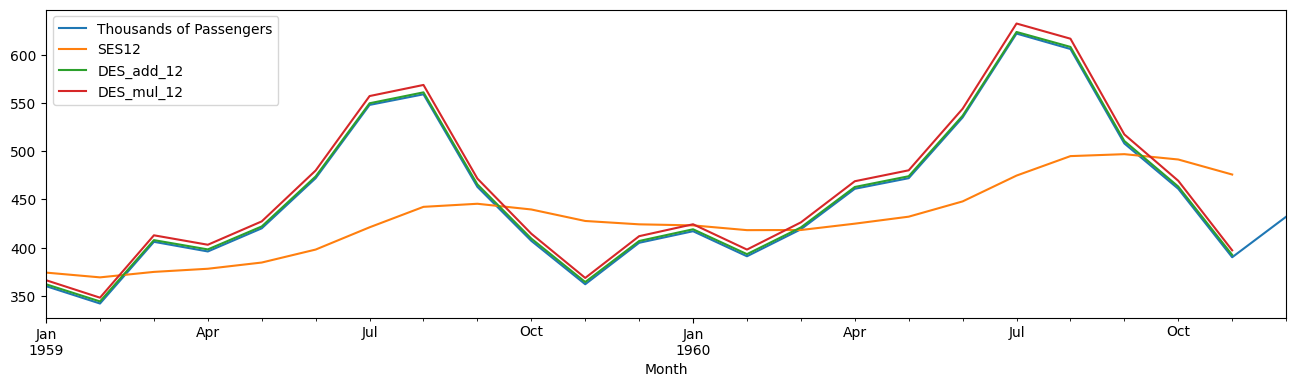

In [28]:
_ = passengers_dataset[['Thousands of Passengers', 
                        'SES12', 
                        'DES_add_12', 
                        'DES_mul_12']].iloc[-24:].plot(figsize=(16, 4))

### Triple Exponential Smoothing

In [29]:
# Multiplicative model
tes_model = ExponentialSmoothing(passengers_dataset['Thousands of Passengers'], 
                                 trend='mul', 
                                 seasonal='mul', 
                                 seasonal_periods=12)
tes_model = tes_model.fit()
passengers_dataset['TES_mul_12'] = tes_model.fittedvalues.shift(-1)

/Users/s.porreca/Projects/TimeWarpForecast/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


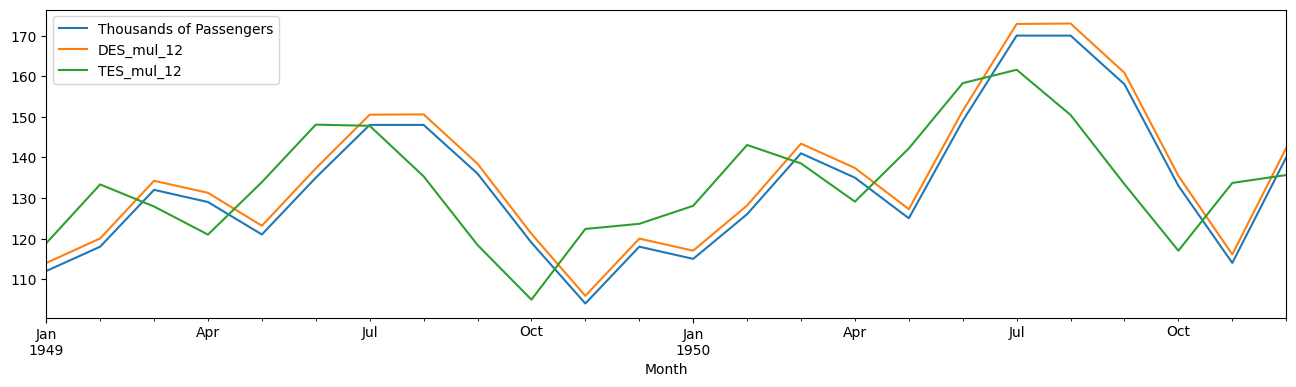

In [30]:
_ = passengers_dataset[['Thousands of Passengers',
                        'DES_mul_12', 
                        'TES_mul_12']].iloc[:24].plot(figsize=(16, 4))

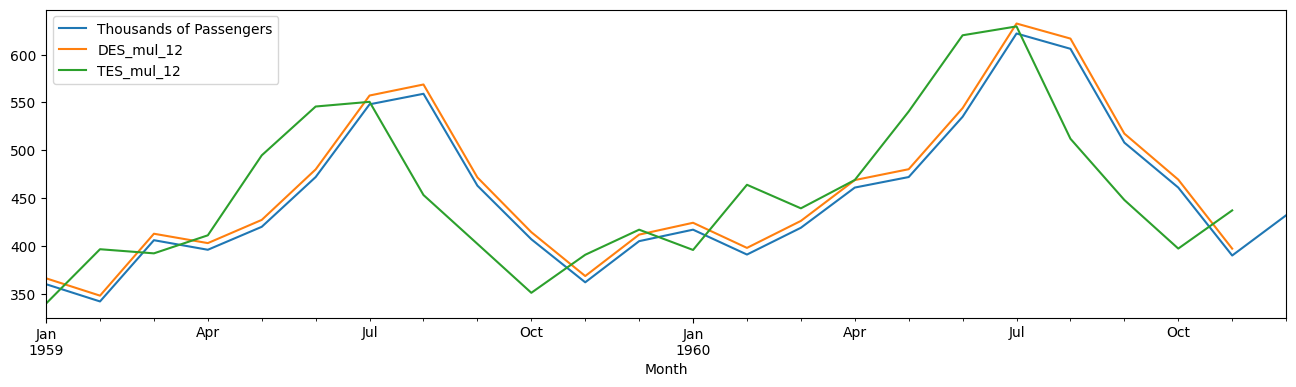

In [31]:
_ = passengers_dataset[['Thousands of Passengers',
                        'DES_mul_12', 
                        'TES_mul_12']].iloc[-24:].plot(figsize=(16, 4))

- Triple Exponential Smoothing performs poor at the start and better at the end of the Time Series

## AutoRegression

In [3]:
# Set the index frequency
us_population.index.freq = 'MS'

In [4]:
# Train & Test split
train_us_population = us_population[:84]
test_us_population = us_population[84:]

In [19]:
# Define model over our Time Series 'Population' using 1-lag feature and fit it
autoregression_model = AutoReg(endog=train_us_population['Population'], lags=1).fit()

In [25]:
# Check the model's parameters once trained
autoregression_model.params.rename('Value')

const            284.913797
Population.L1      0.999686
Name: Value, dtype: float64

In [29]:
# Predict new data points over the time steps of the test dataset
predictions = autoregression_model.predict(start=len(train_us_population),
                                           end=len(train_us_population) + len(test_us_population) - 1).rename('Estimated Population')

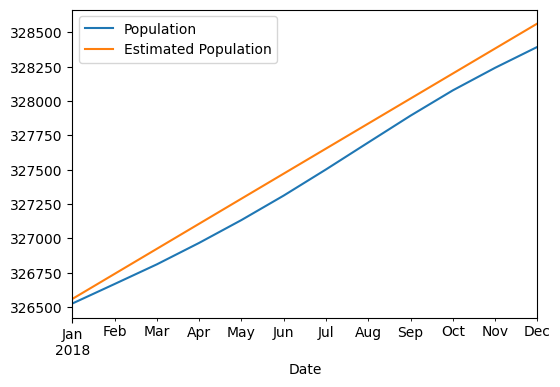

In [34]:
test_us_population.plot(figsize=(6, 4), legend=True)
_ = predictions.plot(legend=True)

Let's now not specify the `lags` parameter, but let's use a Criterion to select the optimal lag length.

In [63]:
# Find the most suitable number of lags for the time series 'Population'
selected_lags = ar_select_order(endog=train_us_population['Population'], maxlag=8)

In [66]:
# Create a model with computed number of lags and fit it
autoregression_model_opt = AutoReg(endog=train_us_population['Population'], lags=selected_lags.ar_lags).fit()

In [67]:
# Predict new data points over the time steps of the test dataset
predictions_opt = autoregression_model_opt.predict(start=len(train_us_population),
                                                   end=len(train_us_population) + len(test_us_population) - 1).rename('Estimated Population OPT')

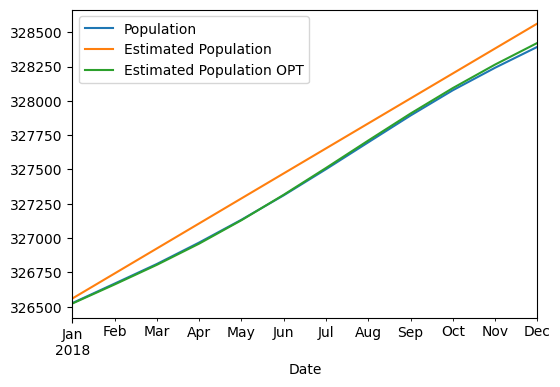

In [68]:
test_us_population.plot(figsize=(6, 4), legend=True)
predictions.plot(legend=True)
_ = predictions_opt.plot(legend=True)

Much better!

## Pyramid ARIMA

The library implements a Grid Search with AIC as metric to find the best (p, q, d) values for ARIMA model.

In [4]:
# Define data
pmdarima_data = daily_female_births.copy()
pmdarima_data.index.freq = 'D'

In [5]:
# Find the best model's parameters
stepwise_fit = auto_arima(pmdarima_data['Births'],
                          start_p=0, start_q=0, max_p=6, max_q=3, # Grid Search Space
                          seasonal=False, # More complex model 
                          trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2650.760, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2565.234, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2463.584, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2648.768, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2460.154, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2461.271, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2460.722, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2536.154, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2463.018, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2459.074, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2462.221, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2563.261, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2460.367, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [6]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1226.537
Date:                Mon, 26 Aug 2024   AIC                           2459.074
Time:                        14:05:44   BIC                           2470.766
Sample:                    01-01-1959   HQIC                          2463.721
                         - 12-31-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1252      0.060      2.097      0.036       0.008       0.242
ma.L1         -0.9624      0.017    -56.429      0.000      -0.996      -0.929
sigma2        49.1512      3.250     15.122      0.000      42.781      55.522
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                25.33
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.57
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- It always returns a SARIMAX model, even though you specify `seasonal=False`
- SARIMAX(p, d, q)

## ARIMA

### ARIMA - ETS

In [4]:
# Define data
arima_stationary_ts = daily_female_births.copy()
arima_stationary_ts.index.freq = 'D'
arima_stationary_ts = arima_stationary_ts[:120]

arima_non_stationary_ts = trade_inventories_data.copy()
arima_non_stationary_ts.index.freq = 'MS'

In [5]:
# First run ETS Decomposition to check Trend and Seasonality
arima_non_stationary_ts_components = seasonal_decompose(arima_non_stationary_ts['Inventories'], model='add')

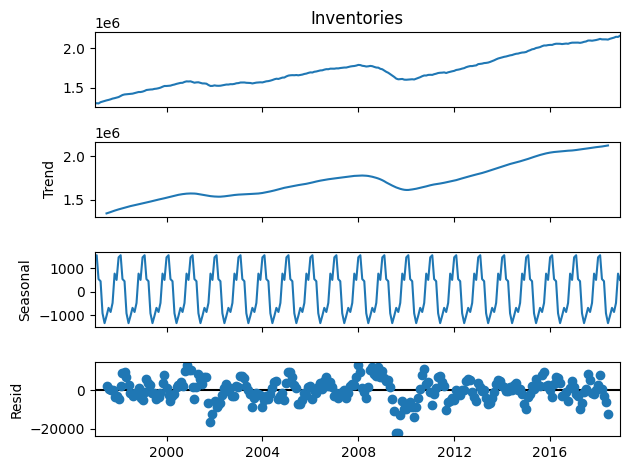

In [6]:
_ = arima_non_stationary_ts_components.plot()

- There are seasonal components, but since they range from -1000 to 1000, they are not visible in the Time Series (which goes from 1.5M to 2.4M) &rarr; We can exclude the Seasonal component from the model

### ARIMA - Stationary Test

In [7]:
# Find the best model's parameters with PMDARIMA
auto_arima(arima_non_stationary_ts['Inventories'],
           seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Wed, 28 Aug 2024   AIC                           5348.037
Time:                        19:37:45   BIC                           5355.181
Sample:                    01-01-1997   HQIC                          5350.908
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Since `d` is equal to 1 (0, 1, 0), it means that by differencing by 1 the time series becomes stationary

In [11]:
# Show the stationarity of order 1 differencing
arima_non_stationary_ts['diff_1'] = diff(arima_non_stationary_ts['Inventories'], k_diff=1)

# Perform ADF test
adf_test = adfuller(arima_non_stationary_ts['diff_1'].iloc[1:])
adf_output = pd.Series(adf_test[0:4], index=['ADF Test Statistics', 
                                           'P-Value', 
                                           '# Lags Used', 
                                           '# Observations']).rename('Value')

In [12]:
adf_output

ADF Test Statistics     -3.412249
P-Value                  0.010548
# Lags Used              4.000000
# Observations         258.000000
Name: Value, dtype: float64

- The `p_value` is not low, thus we can reject the null hypothesis &rarr; Differencing with order 1 produces a stationary time series

### ARIMA - Define "AR" and "MA" Parameters

We need to define the `p` and `q` values. With the Pyramid ARIMA we got 0 and 0. Let's confirm them with the ACF and PACF.

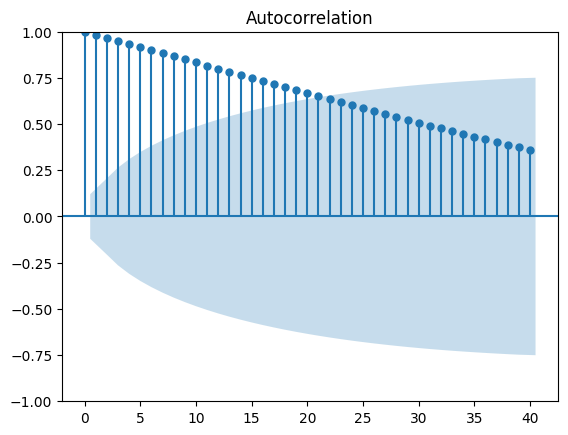

In [13]:
# Plot ACF
_ = plot_acf(arima_non_stationary_ts['Inventories'], lags=40)

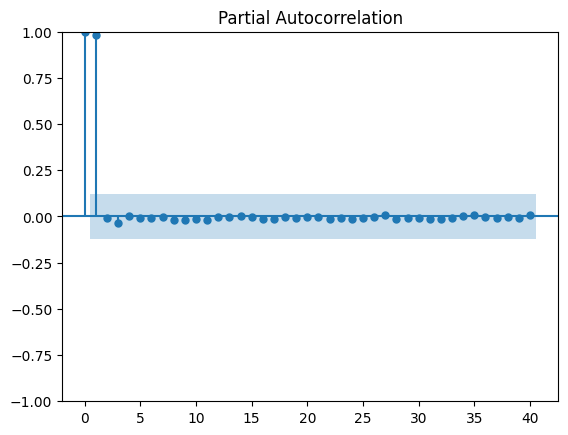

In [14]:
# Plot PACF
_ = plot_pacf(arima_non_stationary_ts['Inventories'], lags=40)

- `p` (AR): If the PACF has a sharp cutoff (as in our case), choose as AR term the lag at which the PACF cutoffs off. The Pmdarima suggests 0, but we can also use 1 from the PACF.
- `q` (MA): If the PACF has a sharp cutoff while ACF decays more slowly, the stationarity is better explain by AR term rather than MA. Therefore `q` can be 0.

### ARIMA - Modeling

In [15]:
# Train & Test split
train_arima = arima_non_stationary_ts.iloc[:252]
test_arima = arima_non_stationary_ts.iloc[252:]

In [19]:
# Define and fit model
arima_model = ARIMA(train_arima['Inventories'], order=(1, 1, 1))
arima_model_results = arima_model.fit()
arima_model_results.summary()

/Users/s.porreca/Projects/TimeWarpForecast/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Inventories   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2560.431
Date:                Wed, 28 Aug 2024   AIC                           5126.863
Time:                        19:56:06   BIC                           5137.439
Sample:                    01-01-1997   HQIC                          5131.119
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.001    848.557      0.000       0.998       1.002
ma.L1         -0.9998      0.022    -45.969      0.000      -1.042      -0.957
sigma2      2.694e+07   5.61e-11    4.8e+17      0.000    2.69e+07    2.69e+07
===================================================================================
Ljung-Box (L1) (Q):                  87.25   Jarque-Bera (JB):                98.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -1.17
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+33. Standard errors may be unstable.
"""

In [38]:
# Compute predictions
arima_model_predictions = arima_model_results.predict(start=len(train_arima), 
                                                      end=len(train_arima) + len(test_arima) - 1).rename('ARIMA(1, 1, 1) Predictions')

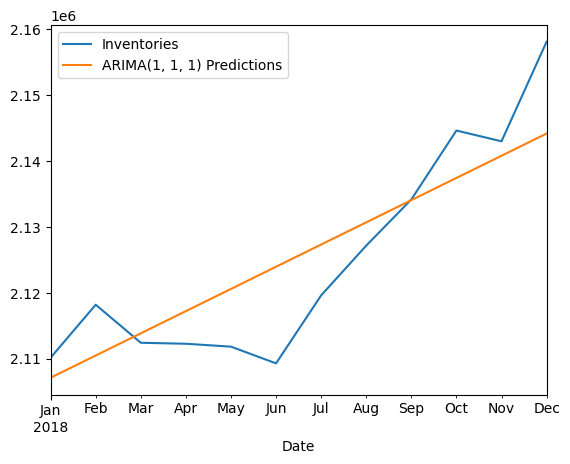

In [39]:
test_arima['Inventories'].plot(legend=True)
_ = arima_model_predictions.plot(legend=True)

- Since seasonal is set to `False`, seasonality is not captured

In [40]:
print(f'RMSE: {rmse(test_arima['Inventories'], arima_model_predictions)}')
print(f'Average: {test_arima['Inventories'].mean()}')

RMSE: 7691.891415159757
Average: 2125075.6666666665


- It still not that bad, since the RMSE is below the average value

## SARIMA

### SARIMA - Data Preparation

In [4]:
# Define data
sarima_data = co2_mm_mlo_data.copy()
sarima_data['date'] = pd.to_datetime({'year': sarima_data['year'], 
                                      'month': sarima_data['month'], 
                                      'day': 1})
sarima_data = sarima_data.set_index('date')
sarima_data.index.freq = 'MS'

### SARIMA - ETS

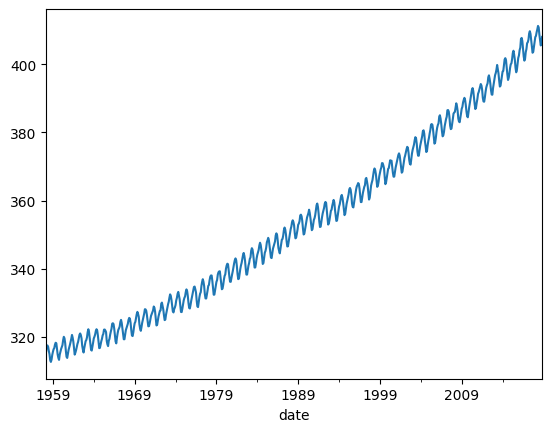

In [6]:
_ = sarima_data['interpolated'].plot()

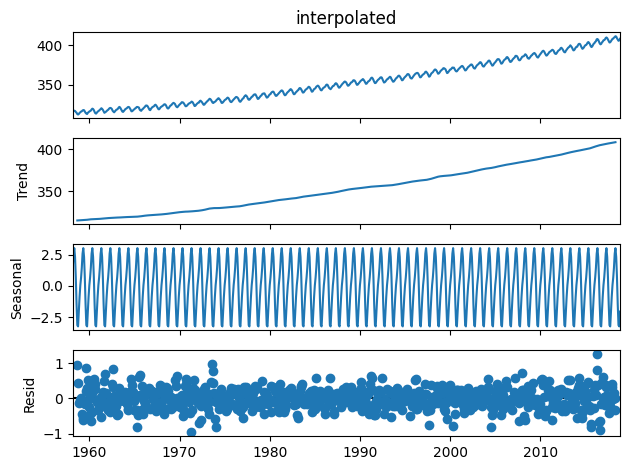

In [7]:
ets_results = seasonal_decompose(sarima_data['interpolated'], model='add')
_ = ets_results.plot()

### SARIMA - Modeling

In [8]:
# Compute parameters
auto_arima(sarima_data['interpolated'], 
           seasonal=True,
           m=12).summary() # From ETS we can derive that the seasonality is monthly-based

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -205.687
Date:                              Thu, 29 Aug 2024   AIC                            423.375
Time:                                      14:50:51   BIC                            450.917
Sample:                                  03-01-1958   HQIC                           434.002
                                       - 11-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3544      0.035    -10.094      0.000      -0.423      -0.286
ma.L2         -0.0228      0.020     -1.132      0.258      -0.062       0.017
ma.L3         -0.0857      0.031     -2.786      0.005      -0.146      -0.025
ar.S.L12       0.9996      0.000   2972.289      0.000       0.999       1.000
ma.S.L12      -0.8673      0.021    -40.833      0.000      -0.909      -0.826
sigma2         0.0955      0.005     20.355      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 4.06
Prob(Q):                              0.76   Prob(JB):                         0.13
Heteroskedasticity (H):               1.13   Skew:                             0.00
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
# Train & Test split
sarima_data_train = sarima_data.iloc[:717]
sarima_data_test = sarima_data.iloc[717:]

In [11]:
# Define the model
sarima_model = SARIMAX(sarima_data_train['interpolated'], order=(0, 1, 3), seasonal_order=(1, 0, 1, 12))

In [12]:
# Fit model
sarima_model_results = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17036D+00    |proj g|=  7.04673D-01

At iterate    5    f=  3.17640D-01    |proj g|=  4.51847D-01


 This problem is unconstrained.



At iterate   10    f=  2.89552D-01    |proj g|=  1.79109D-03

At iterate   15    f=  2.89300D-01    |proj g|=  1.46155D-02

At iterate   20    f=  2.83950D-01    |proj g|=  3.74335D-02

At iterate   25    f=  2.80663D-01    |proj g|=  8.88020D-03

At iterate   30    f=  2.80600D-01    |proj g|=  2.11977D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     47      1     0     0   2.096D-03   2.806D-01
  F =  0.28060041297557237     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [13]:
sarima_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -201.190
Date:                              Thu, 29 Aug 2024   AIC                            414.381
Time:                                      14:52:50   BIC                            441.823
Sample:                                  03-01-1958   HQIC                           424.978
                                       - 11-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3543      0.036     -9.939      0.000      -0.424      -0.284
ma.L2         -0.0242      0.037     -0.662      0.508      -0.096       0.047
ma.L3         -0.0869      0.035     -2.501      0.012      -0.155      -0.019
ar.S.L12       0.9997      0.000   3114.873      0.000       0.999       1.000
ma.S.L12      -0.8667      0.022    -38.581      0.000      -0.911      -0.823
sigma2         0.0949      0.005     20.328      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 4.39
Prob(Q):                              0.78   Prob(JB):                         0.11
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMA - Evaluation

In [14]:
# Compute predictions
sarima_model_predictions = sarima_model_results.predict(start=len(sarima_data_train),
                                                        end=len(sarima_data_train) + len(sarima_data_test) - 1).rename('SARIMA Predictions')

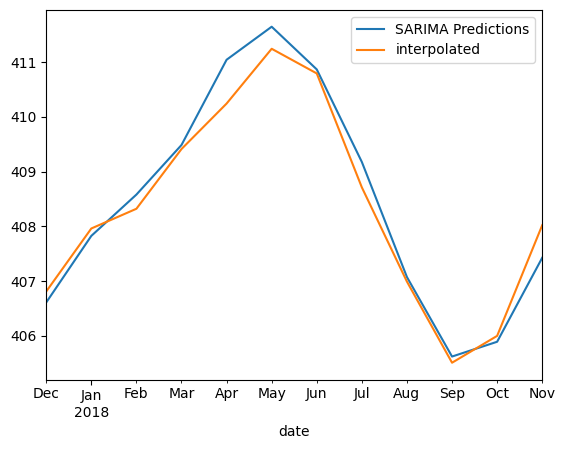

In [16]:
sarima_model_predictions.plot(legend=True)
_ = sarima_data_test['interpolated'].plot(legend=True)

In [17]:
# Forecast the future
sarima_model_full_data = SARIMAX(sarima_data['interpolated'], order=(0, 1, 3), seasonal_order=(1, 0, 1, 12))
sarima_model_full_data_results = sarima_model_full_data.fit()
sarima_model_full_data_future_predictions = sarima_model_full_data_results.predict(start=len(sarima_data), end=len(sarima_data) + 11)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16665D+00    |proj g|=  7.00517D-01

At iterate    5    f=  3.24405D-01    |proj g|=  5.30839D-01


 This problem is unconstrained.



At iterate   10    f=  3.06196D-01    |proj g|=  9.10301D-03

At iterate   15    f=  3.05614D-01    |proj g|=  4.18667D-02

At iterate   20    f=  2.96021D-01    |proj g|=  4.45903D-02

At iterate   25    f=  2.83056D-01    |proj g|=  2.80241D-02

At iterate   30    f=  2.82169D-01    |proj g|=  1.10314D-02

At iterate   35    f=  2.82164D-01    |proj g|=  1.28712D-03

At iterate   40    f=  2.82152D-01    |proj g|=  3.56659D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     76      1     0     0   1.380D-03   2.822D-01
  F =  0.28215015253930076     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

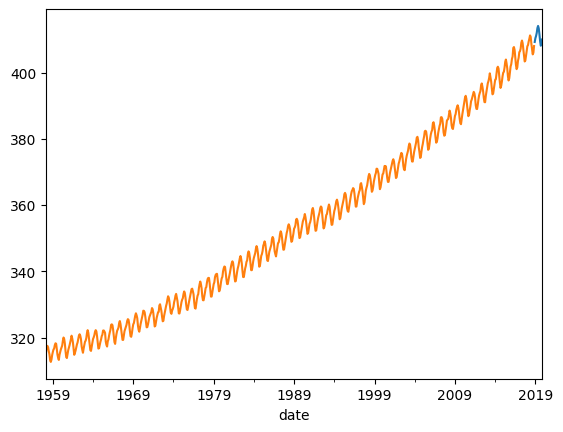

In [19]:
sarima_model_full_data_future_predictions.plot()
_ = sarima_data['interpolated'].plot()

## SARIMAX

### SARIMAX - Data Preparation

In [5]:
# Retrieve data
sarimax_data = restaurant_visitors_data.copy()
sarimax_data.index.freq = 'D'
sarimax_data = sarimax_data.dropna()

In [6]:
# Feature engineering
for column in ['rest1', 'rest2', 'rest3', 'rest4', 'total']:
    sarimax_data[column] = sarimax_data[column].astype(int)

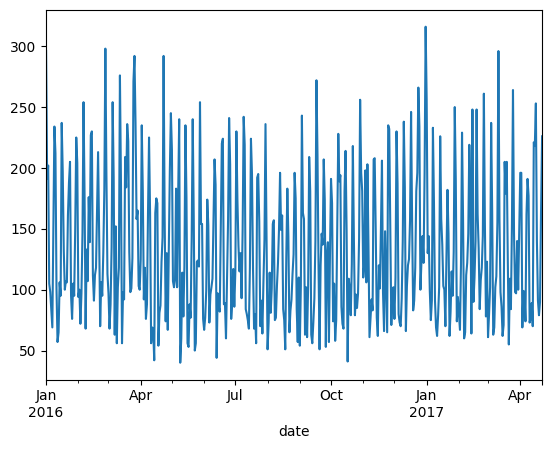

In [7]:
_ = sarimax_data['total'].plot()

### SARIMAX - ETS

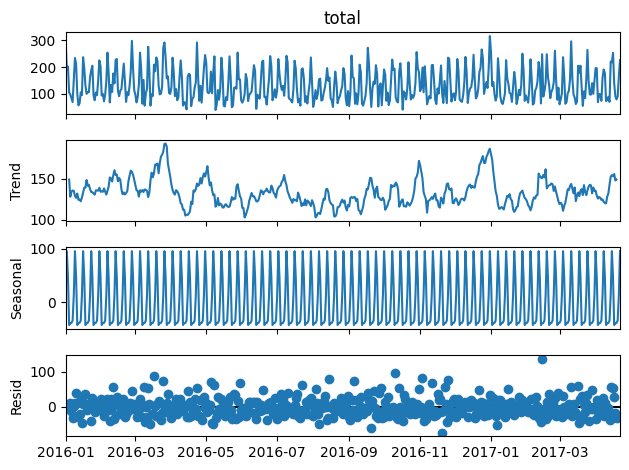

In [8]:
ets_results = seasonal_decompose(sarimax_data['total'], model='add')
_ = ets_results.plot()

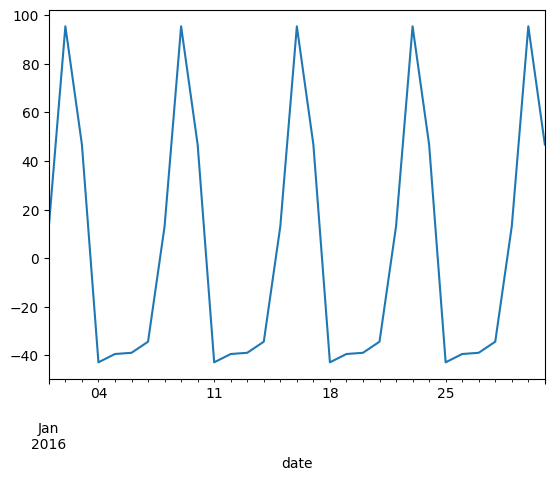

In [11]:
# Zoom into a single month of the seasonal component
_ = ets_results.seasonal['2016-01-01':'2016-01-31'].plot()

- There is clearly a weekly seasonality

### SARIMAX - Modeling

In [ ]:
# Train & Test split
sarimax_data_train = sarimax_data.iloc[:436]
sarimax_data_test = sarimax_data.iloc[436:]

In [12]:
# Compute parameters
auto_arima(sarimax_data['total'], 
           seasonal=True,
           m=7).summary() # Weekly seasonality

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2390.475
Date:                   Thu, 29 Aug 2024   AIC                           4788.949
Time:                           16:11:13   BIC                           4805.628
Sample:                       01-01-2016   HQIC                          4795.506
                            - 04-22-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.2730      1.790      3.504      0.000       2.764       9.782
ar.S.L7        0.9523      0.013     74.740      0.000       0.927       0.977
ma.S.L7       -0.6433      0.047    -13.718      0.000      -0.735      -0.551
sigma2      1148.8882     63.629     18.056      0.000    1024.177    1273.599
===================================================================================
Ljung-Box (L1) (Q):                  14.12   Jarque-Bera (JB):                46.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.62
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Evaluation

### Triple Exponential Smoothing

In [32]:
# Split data
train_data = passengers_dataset[['Thousands of Passengers']].iloc[:109]
test_data = passengers_dataset[['Thousands of Passengers']].iloc[108:]

In [33]:
# Fit model
model = ExponentialSmoothing(train_data['Thousands of Passengers'], 
                                 trend='mul', 
                                 seasonal='mul', 
                                 seasonal_periods=12)
fitted_model = model.fit()
test_predictions = fitted_model.forecast(36)

/Users/s.porreca/Projects/TimeWarpForecast/.venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


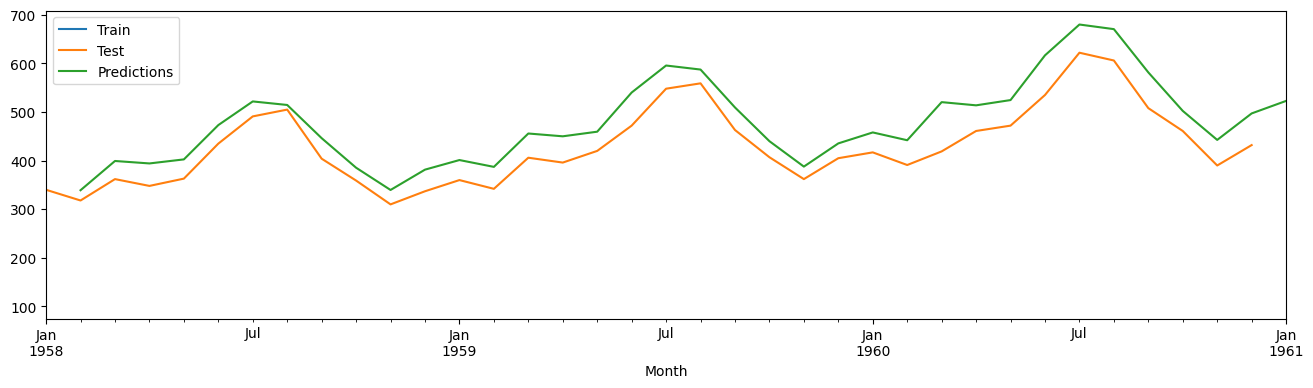

In [34]:
# Plot
train_data['Thousands of Passengers'].plot(legend=True, label='Train', figsize=(16, 4))
test_data['Thousands of Passengers'].plot(legend=True, label='Test', figsize=(16, 4))
_ = test_predictions.plot(legend=True, label='Predictions', figsize=(16, 4), xlim=['1958-01-01', '1961-01-01'])